In [1]:
import sys, os
sys.path.append('../src')
from NeutrinoFogFuncs import *

In [2]:
import numpy as np
from scipy.integrate import quad
import multiprocessing

def matOneHalfGen(mat):
    va, ve = np.linalg.eig(mat)
    if np.any(va<0.):
        return [1.]
    return [ve@np.diag(1/va)@np.transpose(ve), ve@np.diag(np.sqrt(va))@np.transpose(ve)]

def symMatGen(diagTerms, ijTerms):
    n = len(diagTerms)
    myMat = np.zeros((n,n))
    for i in range(0, n-1):
        myMat[i, i+1:] = ijTerms[i]
        myMat[i+1:, i] = ijTerms[i]
    myMat = myMat + np.diag(diagTerms)
    return myMat

def myMatGen(n, b0, deriAs, deri2As, sigmaTheta, sigmaAs, exposure):
    vList = np.sum(b0, axis=0)
    vInvList = 1/vList
    deriList = np.insert(b0,1,deriAs,axis=0)
    deriNuListT = np.transpose(deriList[2:])

    sigmaAs2 = sigmaAs*sigmaAs
    sigmaTheta2 = sigmaTheta*sigmaTheta

    tempVar1 = 0.5*sigmaAs2*deri2As*vInvList
    tempVar2 = np.sum(tempVar1*deriAs)
    temp = vInvList*(1 + tempVar1)
    tempMat = np.zeros((n,n))
    tempMat[0:2,0:2] = np.array([[0.,tempVar2],[tempVar2,np.sum(tempVar1*deri2As)]])
    ijList = [[np.sum(deriList[i]*deriList[j]*temp) for j in range(i+1,n)] for i in range(0,n-1)]
    diagTerms = np.array([np.sum(deriList[i]*deriList[i]*temp) for i in range(0,n)])
    lddTemp = symMatGen(diagTerms, ijList)
    ldd = lddTemp - tempMat 
    ldd = exposure*ldd + np.diag(np.append([0.],1/(np.append([sigmaAs], sigmaTheta)**2)))
    mu = exposure*np.array([np.sum(tempVar1*deri) for deri in deriList])

    nBin = len(vList)
    ijTerms = [[np.sum(deriNuListT[i]*deriNuListT[j]*sigmaTheta2) for j in range(i+1,nBin)] for i in range(0,nBin-1)]
    diagTerms = [np.sum(deriNuListT[i]*deriNuListT[i]*sigmaTheta2) for i in range(0,nBin)]
    varGauTermConst = np.outer(vInvList, vInvList)*(symMatGen(diagTerms, ijTerms) \
                     + (np.outer(deriAs, deriAs))*sigmaAs2- (0.5*sigmaAs2)**2*np.outer(deri2As, deri2As))
    varGauTermIJ = [[np.sum(np.outer(deriList[i], deriList[j])*varGauTermConst)\
                             for j in range(i+1,n)] for i in range(0,n-1)]
    varGauTermDiag = [np.sum(np.outer(deriList[i], deriList[i])*varGauTermConst)\
                             for i in range(0,n)]
    varGauTerm = symMatGen(varGauTermDiag, varGauTermIJ)
    varMat = exposure*lddTemp + exposure**2*varGauTerm

    nk = n - 2
    G3 = ldd.copy()[2:,2:]
    HMat = np.block([[np.zeros((2,2)), np.zeros((2,nk))],[np.zeros((nk,2)), np.linalg.inv(G3)]])
    return [ldd, HMat, varMat, mu]

class DLLSRVec(object):
    
    def __init__(self, mDM, E_th, E_max, ne):
        self._E_th, self._E_max, self._ne = E_th, E_max, ne
        self._sData, self._deriAs, self._deri2As = self._deriV0Gen(mDM)
        
    def _deriV0Gen(self, mDM):
        dd = 1.0e-4
        xList = np.array([-1.,0,1.])*dd + 1.
        m = np.array([mDM])
        yList = np.array([BinnedWIMPRate2(self._E_th, self._E_max, self._ne,m,Nuc,C_SI,FormFactorHelm,\
                                      lambda v_min: MeanInverseSpeed_SHM(v_min,sig_v=167.0*x,v_esc=533.0,v_lab=245.6))[1][0] \
                        for x in xList])
        deri1List = (yList[2]-yList[0])/(2*dd)
        deri2List = (yList[2]+yList[0]-2*yList[1])/(dd*dd)
        return yList[1], deri1List, deri2List
    
    def distributionPara(self, b, sigmaTheta, sigmaAs, exposure, sigma0):
        n = len(b)+2
        b0 = np.append([self._sData*10**(sigma0+45.)], b, axis=0)
        deriAs = self._deriAs*10**(sigma0+45.)
        deri2As = self._deri2As*10**(sigma0+45.)
        
        ldd, HMat, varMat, mu = myMatGen(n, b0, deriAs, deri2As, sigmaTheta, sigmaAs, exposure)
        
        temp = matOneHalfGen(ldd)
        if len(temp)==1:
            return [1]
        lddInv, lddOneHalf = temp
        temp = matOneHalfGen(varMat)
        if len(temp)==1:
            return [2]
        varMatInv, varMatOneHalf = temp
        varMatOneHalfInv = np.linalg.inv(varMatOneHalf)
    
        res1 = varMatOneHalf@(lddInv - HMat)@varMatOneHalf
        res2 = np.linalg.eigh(res1)
        orderList = np.flip(np.argsort(res2[0]))
        res2 = [res2[0][orderList], np.transpose(res2[1])[orderList]]
        res3 = varMatOneHalfInv@(mu+ldd@np.append([1.],np.zeros(n-1)))
        return [res2[0][0:2], (res2[1][0:2]@res3)**2]
    
    def _betaGen(self, b, sigmaTheta, sigmaAs, exposure, sigma0):
        temp = self.distributionPara(b, sigmaTheta, sigmaAs, exposure, sigma0)
        if len(temp)>1:
            res = cumFunc(temp[0],temp[1],9.)
        # The numerical fails and let the cross section become smaller for the correct result.
        else:
            res = 0.01
        return res
    
    def phiGen(self, b, sigmaTheta, exposure, sigma0):
        n_nu = len(b)
        s = self._sData*10**(sigma0+45.)
        temp = s + np.sum(b, axis=0)
        derList = [[exposure*np.sum(b[i]*x/temp) for x in b[i+1:]] for i in range(n_nu-1)]
        G1 = exposure*np.sum(s*s/temp)
        G2 = exposure*np.array([np.sum(s*x/temp) for x in b])
        G3 = np.zeros((n_nu,n_nu))
        for i in range(0, n_nu-1):
            G3[i,i+1:] = derList[i]
            G3[i+1:, i] = derList[i]
        diagTerm = 1/(sigmaTheta*sigmaTheta)+exposure*np.array([np.sum(x*x/temp) for x in b])
        G3 = G3+np.diag(diagTerm)
        res = G1 - G2@np.linalg.inv(G3)@G2
        return res
    
    # Beta represents for the Type-II error in the statistic.
    def _sigmaBeta(self, paraSet, sigma0Log):
        RNu, NuUncs, sigmaAs, exposure, beta = paraSet
        temp = self._betaGen(RNu, NuUncs, sigmaAs, exposure, sigma0Log)-beta
        #print(exposure,' ', sigma0Log, ' ', temp)
        if temp>0:
            return [0, temp]
        else:
            return [1, temp]

    def sigmaExpoGen(self, sigmaInit, RNu, NuUncs, sigmaAs, exposure, beta):
        RWIMP = self._sData
        [sigmaLog, temp, recordDat] = biSearch(0.5, 6, self._sigmaBeta, \
                                [RNu, NuUncs, sigmaAs, exposure, beta], sigmaInit, 0)
        return [exposure, sigmaLog, recordDat]

def cumFunc(cList, phiList, x):
    quadFunc = lambda t: np.imag((1-np.exp(-1j*x*t))*\
                    np.exp(-np.sum((cList*t*phiList)/(1j+2*cList*t)))/(t*np.prod(np.sqrt(1-2j*cList*t))))
    return (quad(quadFunc, 1.0e-6, 50.)[0])*2/(2*np.pi)

In [3]:
def massScan1(massList, sigmaAs, exposure):
    step0 = 1.
    sigmaInit = -45.
    resList = []
    for i in range(len(massList)):
        res = DLLSRVec(massList[i], E_th1, E_max, ne).sigmaExpoGen(sigmaInit, R_nu1, NuUnc1, sigmaAs, exposure, 0.1)
        resList.append(res)
        sigmaInit = res[1]
    return resList

def massScan2(massList, sigmaAs, exposure):
    step0 = 1.
    sigmaInit = -48.
    resList = []
    for i in range(len(massList)):
        res = DLLSRVec(massList[i], E_th2, E_max, ne).sigmaExpoGen(sigmaInit, R_nu2, NuUnc2, sigmaAs, exposure, 0.1)
        resList.append(res)
        sigmaInit = res[1]
    return resList

In [4]:
from NeutrinoFuncs import BinnedNeutrinoRates, BinnedNeutrinoRates2
from WIMPFuncs import BinnedWIMPRate,MeanInverseSpeed_SHM,C_SI, BinnedWIMPRate2
from LabFuncs import FormFactorHelm
from Params import *
#==============================================================================#
ne = 50 # number of energy bins (anything >50 is accurate enough)
nm = 200 # number of mass points
m_vals = np.logspace(log10(0.1),log10(1.0e4),nm) # mass points
Flux_norm = NuFlux # See Params.py
Flux_err = NuUnc # See Params.py
E_th = 1.0e-4 # Threshold
E_max = 200.0 # Max recoil energy

Nuc = Xe131

In [5]:
E_th1 = 1.0e-4
nunames1, NuUnc1, R_nu1 = BinnedNeutrinoRates2(E_th1,E_max,ne,Nuc,Flux_norm)
mDMList1 = np.logspace(-1.,1.,100)
dmMassList1, R_sig1 = BinnedWIMPRate2(E_th1,E_max,ne,mDMList1,Nuc,C_SI,FormFactorHelm,MeanInverseSpeed_SHM)

In [6]:
phi = 18.32
exposureList1 = [1.0, 10.]
sigmaAsList = [0.12703, 0.21171]
fogDatGen1 = Fog(phiGen1)
res10 = [[fogDatGen1.sigmaExpoListGen(np.array([exposure]), R_sig1[i], \
                                                      R_nu1, NuUnc1, phi) for i in range(len(R_sig1))] for exposure in exposureList1]

In [7]:
DL10Dat = [np.array([10**myFindRoot(d[2][0]) for d in dat]).flatten() for dat in res10]

In [8]:
%%time
pool = multiprocessing.Pool(4)
multiple_results = [pool.apply_async(\
        massScan1, (mDMList1, sigmaAsList[1], exposure))\
                                     for exposure in exposureList1]
pool.close()
pool.join()
res12= [res.get() for res in multiple_results]
# %time res12 = [massScan1(mDMList1, sigmaAsList[1], exposureList1[0]), massScan1(mDMList1, sigmaAsList[1], exposureList1[1])]

CPU times: user 30.9 ms, sys: 44.1 ms, total: 75 ms
Wall time: 31.7 s


In [9]:
DL12Dat = [np.array([10**myFindRoot(d[2]) for d in dat]).flatten() for dat in res12]

Text(1.9, 1.22e-46, '$E_{th}$ = 0.1 eV')

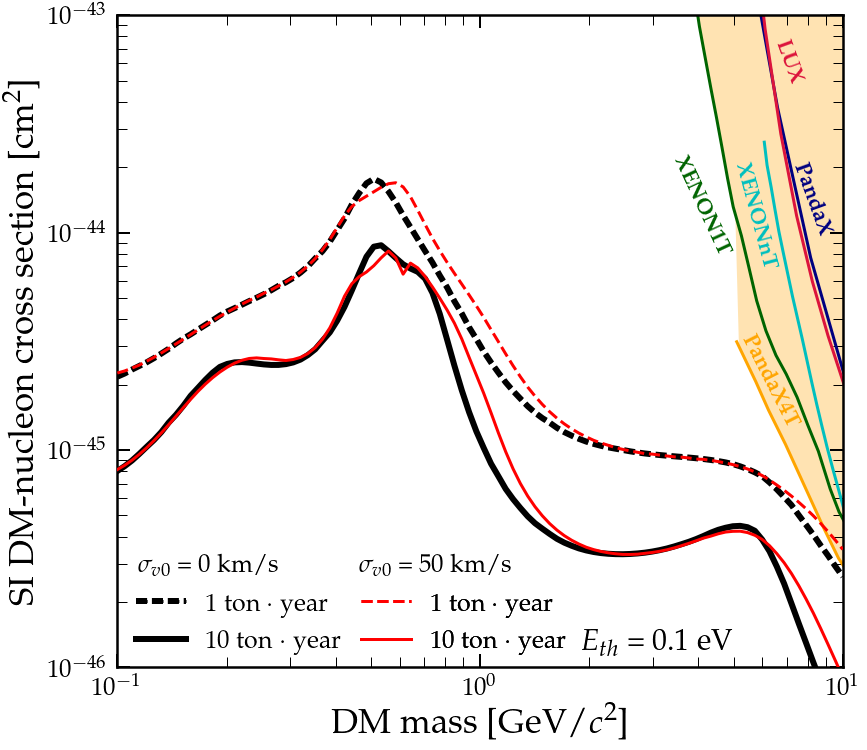

In [10]:
import matplotlib.pyplot as plt
from Like import *
from PlotFuncs import *

def MakeLimitPlot_LSR_Low(xmin=0.1,xmax=1.0e4,ymax=1.0e-36,ymin=1.0e-51,\
                     facecolor=[0.0, 0.62, 0.38],edgecolor='darkgreen',edgecolor_collected='darkgray',\
                     alph=0.5,lfs=35,tfs=25,\
                     xlab=r"DM mass [GeV$/c^2$]",ylab=r"SI DM-nucleon cross section [cm$^2$]"):
    pek = line_background(5,'k')

    fig,ax = MySquarePlot(xlab,ylab,lfs=lfs,tfs=tfs)

    plt.text(7.1,1.0e-44,r"{\bf PandaX}",color="navy",fontsize=22,rotation=-70)
    plt.text(3.3,8.0e-45,r"{\bf XENON1T}",color="darkgreen",fontsize=22,rotation=-65)
    plt.text(6.3,5.0e-44,r"{\bf LUX}",color="crimson",fontsize=22,rotation=-70)
    plt.text(4.9,7.0e-45,r"{\bf XENONnT}",color="c",fontsize=22,rotation=-75)
    plt.text(5.1,1.3e-45,r"{\bf PandaX4T}",color="orange",fontsize=22,rotation=-63)
    
    PandaX = loadtxt("../data/WIMPLimits/SI/PandaX.txt")
    plt.plot(PandaX[:,0], PandaX[:,1],color="navy",linewidth=3)

    XENON1T = loadtxt("../data/WIMPLimits/SI/XENON1T.txt")
    plt.plot(XENON1T[:,0], XENON1T[:,1],color=edgecolor,linewidth=3)
    
    LUX = loadtxt('../data/WIMPLimits/SI/LUX.txt')
    plt.plot(LUX[:,0], LUX[:,1],color='crimson',linewidth=3)
    
    XENONnT = loadtxt("../data/WIMPLimits/SI/XENONnT.txt")
    plt.plot(XENONnT[:,0], XENONnT[:,1],color='c',linewidth=3)
    
    PandaX4T = loadtxt("../data/WIMPLimits/SI/PandaX4T.txt")
    plt.plot(PandaX4T[:,0], PandaX4T[:,1],color='orange',linewidth=3)
    
    AllLimits = loadtxt("../data/WIMPLimits/SI/AllLimits-2023.txt")
    plt.fill_between(AllLimits[:,0], AllLimits[:,1],edgecolor=None,y2=ymax,facecolor="orange",alpha=0.3,zorder=0)

    # Labels
    plt.yscale('log')
    plt.xscale('log')
    plt.yticks(10.0**arange(-51,-30,1),fontsize=25)
    ax.tick_params(which='major',pad=10)
    ax.set_xlim(left=xmin, right=xmax)
    ax.set_ylim(bottom=ymin, top=ymax)
    return fig,ax

alph = 0.7
nufloor_col = '#e68525'
pek = line_background(6,'k')

#fig,ax = MakeLimitPlot_SI(Annotations=True,Collected=False,ymin=1.0e-50,ymax=1e-37)
fig,ax = MakeLimitPlot_LSR_Low(xmin=1.0e-1,xmax=1.0e1,ymin=1e-46,ymax=1e-43)

# Our result
line1, = ax.plot(mDMList1,DL10Dat[0],'--',label='1 ton $\cdot$ year',color='black',lw=3,path_effects=pek,zorder=50)
line2, = ax.plot(mDMList1,DL10Dat[1],'-',label='10 ton $\cdot$ year',color='black',lw=3,path_effects=pek,zorder=50)
line3, = ax.plot(mDMList1,DL12Dat[0],'--',label='1 ton $\cdot$ year',color='r',lw=3,zorder=50)
line4, = ax.plot(mDMList1,DL12Dat[1],'-',label='10 ton $\cdot$ year',color='r',lw=3,zorder=50)

ax.add_artist(ax.legend(handles=[line1,line2], bbox_to_anchor=(0.34, 0.15), frameon=False))
ax.add_artist(ax.legend(handles=[line3,line4], bbox_to_anchor=(0.65, 0.15), frameon=False))

ax.annotate('$\sigma_{v 0}$ = 0 km/s', xy=(0.114,2.8e-46))
ax.annotate('$\sigma_{v 0}$ = 50 km/s', xy=(0.465,2.8e-46))
ax.annotate('$E_{th}$ = 0.1 eV', xy=(1.9,1.22e-46), size=30)

#plt.legend(loc='lower left',frameon=False,handletextpad=0.5)

In [11]:
myPathFig = os.path.join(os.path.abspath(os.path.pardir),'plots')
fig.savefig(os.path.join(myPathFig,'LSRLow.pdf'),bbox_inches='tight')
fig.savefig(os.path.join(myPathFig,'png','LSRLow.png'),bbox_inches='tight')

In [12]:
E_th2 = 4.0e0
nunames2, NuUnc2, R_nu2 = BinnedNeutrinoRates2(E_th2,E_max,ne,Nuc,Flux_norm)
mDMList2 = np.logspace(1.,3.,100)
dmMassList2, R_sig2 = BinnedWIMPRate2(E_th2,E_max,ne,mDMList2,Nuc,C_SI,FormFactorHelm,MeanInverseSpeed_SHM)

In [13]:
exposureList2 = [1.0e3, 1.0e4]
fogDatGen2 = Fog(phiGen2)
res20 = [[fogDatGen1.sigmaExpoListGen(np.array([exposure]), R_sig2[i], \
                                                      R_nu2, NuUnc2, phi) for i in range(len(R_sig2))] for exposure in exposureList2]

In [14]:
DL20Dat = [np.array([10**myFindRoot(d[2][0]) for d in dat]).flatten() for dat in res20]

In [15]:
%%time
pool = multiprocessing.Pool(4)
multiple_results = [pool.apply_async(\
        massScan2, (mDMList2, sigmaAsList[1], exposure))\
                                     for exposure in exposureList2]
pool.close()
pool.join()
res22= [res.get() for res in multiple_results]

CPU times: user 7.4 ms, sys: 40.2 ms, total: 47.6 ms
Wall time: 31.9 s


In [16]:
DL22Dat = [np.array([10**myFindRoot(d[2]) for d in dat]).flatten() for dat in res22]

Text(210, 1.25e-50, '$E_{th}$ = 4 keV')

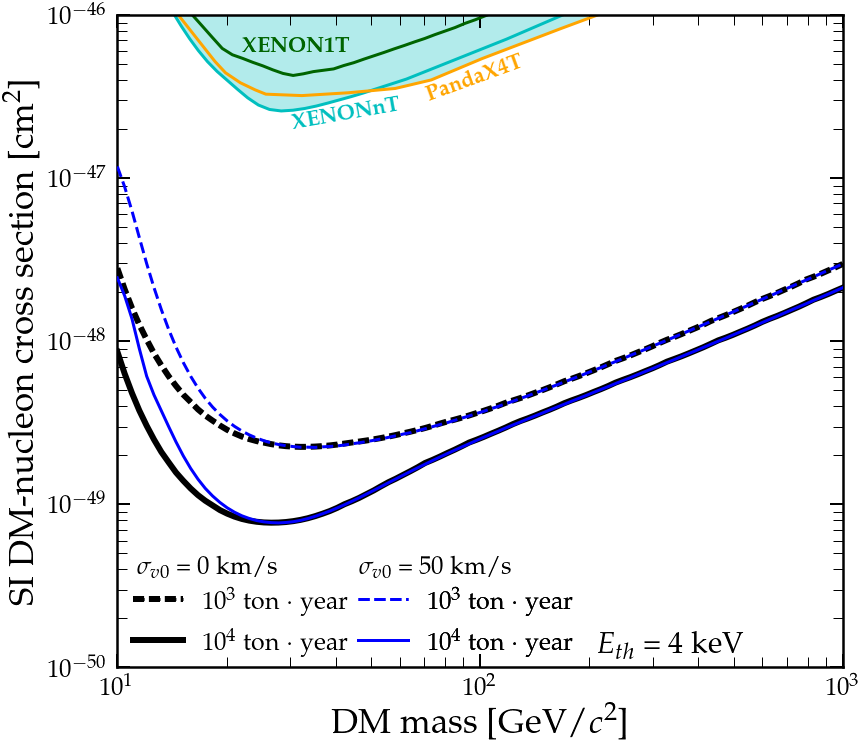

In [17]:
def MakeLimitPlot_LSR_High(xmin=0.1,xmax=1.0e4,ymax=1.0e-36,ymin=1.0e-51,\
                     facecolor=[0.0, 0.62, 0.38],edgecolor='darkgreen',edgecolor_collected='darkgray',\
                     alph=0.5,lfs=35,tfs=25,\
                     xlab=r"DM mass [GeV$/c^2$]",ylab=r"SI DM-nucleon cross section [cm$^2$]"):
    pek = line_background(5,'k')

    fig,ax = MySquarePlot(xlab,ylab,lfs=lfs,tfs=tfs)

    plt.text(22.0,6.0e-47,r"{\bf XENON1T}",color="darkgreen",fontsize=22,rotation=0)
    
    plt.text(30.0,2.e-47,r"{\bf XENONnT}",color="c",fontsize=22,rotation=10)
    plt.text(70.0,3.0e-47,r"{\bf PandaX4T}",color="orange",fontsize=22,rotation=20)

    XENON1T = loadtxt("../data/WIMPLimits/SI/XENON1T.txt")
    plt.plot(XENON1T[:,0], XENON1T[:,1],color=edgecolor,linewidth=3)
    
    XENONnT = loadtxt("../data/WIMPLimits/SI/XENONnT.txt")
    plt.plot(XENONnT[:,0], XENONnT[:,1],color='c',linewidth=3)
    
    PandaX4T = loadtxt("../data/WIMPLimits/SI/PandaX4T.txt")
    plt.plot(PandaX4T[:,0], PandaX4T[:,1],color='orange',linewidth=3)
    
    AllLimits = loadtxt("../data/WIMPLimits/SI/AllLimits-2023.txt")
    plt.fill_between(AllLimits[:,0], AllLimits[:,1],edgecolor=None,y2=ymax,facecolor="c",alpha=0.3,zorder=0)
    

    # Labels
    plt.yscale('log')
    plt.xscale('log')
    plt.yticks(10.0**arange(-51,-30,1),fontsize=25)
    ax.tick_params(which='major',pad=10)
    ax.set_xlim(left=xmin, right=xmax)
    ax.set_ylim(bottom=ymin, top=ymax)
    return fig,ax

alph = 0.7
nufloor_col = '#e68525'
pek = line_background(6,'k')

#fig,ax = MakeLimitPlot_SI(Annotations=True,Collected=False,ymin=1.0e-50,ymax=1e-37)
fig,ax = MakeLimitPlot_LSR_High(xmin=1.0e1,xmax=1.0e3,ymin=1e-50,ymax=1e-46)

# Our result
line1, = ax.plot(mDMList2,DL20Dat[0],'--',label='$10^3$ ton $\cdot$ year',color='black',lw=3,path_effects=pek,zorder=50)
line2, = ax.plot(mDMList2,DL20Dat[1],'-',label='$10^4$ ton $\cdot$ year',color='black',lw=3,path_effects=pek,zorder=50)
line3, = ax.plot(mDMList2,DL22Dat[0],'--',label='$10^3$ ton $\cdot$ year',color='b',lw=3,zorder=50)
line4, = ax.plot(mDMList2,DL22Dat[1],'-',label='$10^4$ ton $\cdot$ year',color='b',lw=3,zorder=50)

ax.add_artist(ax.legend(handles=[line1,line2], bbox_to_anchor=(0.35, 0.16), frameon=False))
ax.add_artist(ax.legend(handles=[line3,line4], bbox_to_anchor=(0.66, 0.16), frameon=False))

ax.annotate('$\sigma_{v 0}$ = 0 km/s', xy=(11.3,3.8e-50))
ax.annotate('$\sigma_{v 0}$ = 50 km/s', xy=(46.5,3.8e-50))
ax.annotate('$E_{th}$ = 4 keV', xy=(210,1.25e-50), size=30)
#plt.legend(loc='lower left',frameon=False,handletextpad=0.5)

In [18]:
myPathFig = os.path.join(os.path.abspath(os.path.pardir),'plots')
fig.savefig(os.path.join(myPathFig,'LSRHigh.pdf'),bbox_inches='tight')
fig.savefig(os.path.join(myPathFig,'png','LSRHigh.png'),bbox_inches='tight')